In [36]:
import pandas as pd
import utm
import numpy as np
from scipy import stats
import h2o
from h2o.automl import H2OAutoML
seed = 38 # Seed for train/val split

In [37]:
# Specify data paths
train_data = 'Example_data\Output\Train_test_data\Training_Tag_GPS_locations.xlsx'
test_data = 'Example_data\Output\Train_test_data\Testing_Tag_GPS_locations.xlsx'
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'

# Variable parameters
freq = '5min' # Frequency of data

# Fixed parameters
data_type = ['Simulated BTFS', 'BTFS'] # Simulation or Live BTF, or could do both
dimensions = ['xOffset', 'yOffset']
predictors = ['ant1_mean', 'ant2_mean', 'ant3_mean', 'ant4_mean', 'ant1_count', 'ant2_count', 'ant3_count', 'ant4_count', 'ant1_std', 'ant2_std', 'ant3_std', 'ant4_std', 'mean_std', 'total_count']
# responses = ['xOffset', 'yOffset']
# scoring = 'neg_mean_absolute_error'

In [38]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [39]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]
    
    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))
  
    # group by datetime, tag, tower and antenna, compute mean power and std power, pivot to antennas
    sim_dat_filt = (
            sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
            .agg(['mean', 'count', np.std])
            .reset_index()
            .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values=['mean', 'count', 'std'])
            .reset_index()
        )
    
    # Rename columns
    sim_dat_filt.columns = [f"{col[0]}{col[1]}" if col[1] != "" else col[0] for col in sim_dat_filt.columns.values]
    sim_dat_filt = sim_dat_filt.rename(columns={ 'mean1': 'ant1_mean', 'mean2': 'ant2_mean', 'mean3': 'ant3_mean', 'mean4': 'ant4_mean',
                                                  'count1': 'ant1_count', 'count2': 'ant2_count', 'count3': 'ant3_count', 'count4': 'ant4_count',
                                                  'std1': 'ant1_std', 'std2': 'ant2_std', 'std3': 'ant3_std', 'std4': 'ant4_std'})
    
    # Calculate the mean std and total count across the antennas
    sim_dat_filt['mean_std'] = sim_dat_filt[['ant1_std', 'ant2_std', 'ant3_std', 'ant4_std']].mean(axis=1)
    sim_dat_filt['total_count'] = sim_dat_filt[['ant1_count', 'ant2_count', 'ant3_count', 'ant4_count']].sum(axis=1)

    # Fill missing values with 0
    sim_dat_filt = sim_dat_filt.fillna(value=0)
     
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)
    
    return sim_dat_filt

In [40]:
#Convert locations predictions back to easting northings

def postprocess_data(prediction_data, tower_locs):
    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Change predicted x/y offset values to their respective easting/northing considering the location of the tower
    prediction_data['easting_pred'] = prediction_data['xOffset_pred'] + prediction_data['TowerID'].map(point_x).fillna(0)
    prediction_data['northing_pred'] = prediction_data['yOffset_pred'] + prediction_data['TowerID'].map(point_y).fillna(0)
    
    return prediction_data

In [41]:
# Get training data
train_data = pd.read_excel(train_data)
train_data['DateAndTime'] = pd.to_datetime(train_data['DateAndTime'])

# Get testing data
test_data = pd.read_excel(test_data)
test_data['DateAndTime'] = pd.to_datetime(test_data['DateAndTime'])

# Get tower locations
tower_locs = pd.read_excel(radio_tower_xy_path)

In [43]:
# Preprocess the training and testing data
train_data_preproc = preprocess_sim_data(train_data, data_type, freq, tower_locs)
test_data_preproc = preprocess_sim_data(test_data, data_type, freq, tower_locs)

# Initialise h2o
h2o.init()

# Train, save and test the models for each dimension
for dimension in dimensions:
    print(f"Training model for {dimension}")
    # Train the model
    variables = predictors + [dimension]
    training_input = train_data_preproc[variables]
    train = h2o.H2OFrame(training_input)
    aml = H2OAutoML(max_models=20, seed=seed, stopping_metric='MAE', sort_metric='MAE')
    aml.train(x=predictors, y=dimension, training_frame=train)
    print(aml.leaderboard)

    # Save the leader model
    h2o.save_model(aml.leader, path = f"Example_data\Output\Trained_models\{dimension}", force=True)

    # Make predictions on the test data
    test = h2o.H2OFrame(test_data_preproc)
    preds = aml.leader.predict(test)

    # Save predictions to a new column in the test dataframe
    pred_column_name = f"{dimension}_pred"
    test_data_preproc[pred_column_name] = preds.as_data_frame()

# Stop h2o
h2o.cluster().shutdown()


Checking whether there is an H2O instance running at http://localhost:54321.

KeyboardInterrupt: 

In [ ]:
# Calculate the accuracy of the predictions

test_predictions = postprocess_data(test_data_preproc, tower_locs)

UTM_predictions = (test_predictions.groupby(['DateTime', 'TagID'], as_index=False)
    .agg({'easting':'first',
        'northing':'first',
        'easting_pred':'mean',
        'northing_pred':'mean'
        })
)

# Calculate the Eucledian distance between the predicted and actual locations
UTM_predictions['distance'] = np.sqrt((UTM_predictions['easting'] - UTM_predictions['easting_pred']) ** 2
                    + (UTM_predictions['northing'] - UTM_predictions['northing_pred']) ** 2)

# Calculate the mean absolute error of UTM_predictions['distance'] and the standard error
mean_error = np.mean(UTM_predictions['distance'])
std_error = stats.sem(UTM_predictions['distance'])

print(f'Mean error (+/-SE) = {mean_error} (+/- {std_error})')

Mean error (+/-SE) = 227.51732641940026 (+/- 15.595555121747932)


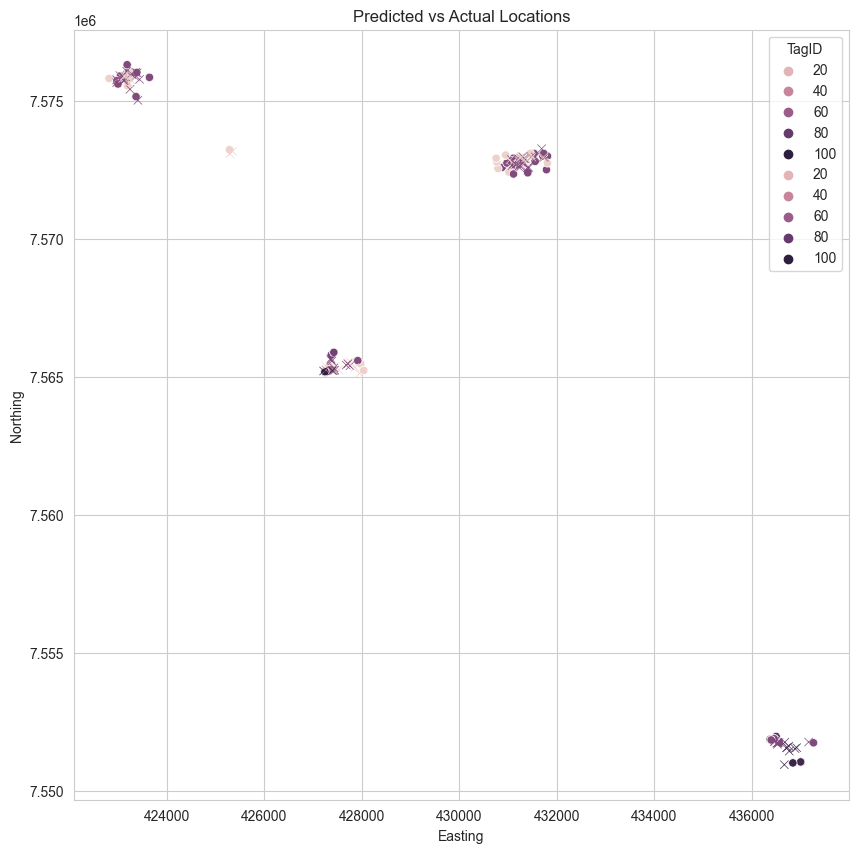

In [ ]:
# Plot the predicted and actual locations
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=UTM_predictions, x='easting', y='northing', hue='TagID', ax=ax)
sns.scatterplot(data=UTM_predictions, x='easting_pred', y='northing_pred', hue='TagID', ax=ax, marker='x')
ax.set_title('Predicted vs Actual Locations')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

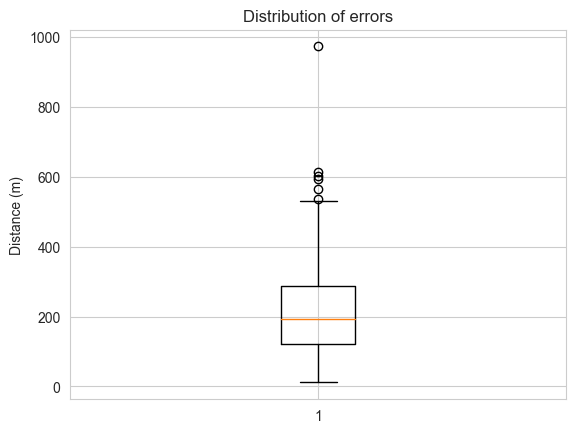

In [ ]:
# Plot the distribution of the errors
def plot_error_distribution(distances):
    fig, ax = plt.subplots()
    ax.boxplot(distances)
    ax.set_ylabel('Distance (m)')
    ax.set_title('Distribution of errors')
    plt.show()

plot_error_distribution(UTM_predictions['distance'])